In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Transformation Et Manipulation Des Données<br>
    </h1>
    MovieLens - Système de recommendations de films par regroupement<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <br>
    420-A56<br>
    <br>
</center>

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

from fanalysis.base import Base
from fanalysis.mca import MCA

from tqdm.notebook import tqdm


#
# imports faisant partie de mes propres modules
#
import helpers as hlp
import helpers.dataset.MovieLens as mvl
import helpers.Clustering as clstr
import helpers.jupyter as jup

# Exploration

**ATTENTION** il faut exécuter Pretraitement.ipynb avant celui-ci

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

In [4]:
# imdbId doit etre garde en string (leading 0)
# voir la partie pretraitement pour comprendre pourquoi rating_mode et rating_median sont en string
movies_df = pd.read_csv("dataset/movies_pretraitement.csv", 
                        dtype={"imdbId": str,
                               "rating_mode": str,
                               "rating_median": str})

print("Movies", movies_df.shape)
print("Head")
display(movies_df.head().round(2))
clstr.show_na(movies_df)
clstr.show_types(movies_df)

Movies (9460, 9)
Head


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
0,1,0114709,Toy Story (1995),Comedy|Fantasy|Children|Animation|Adventure,1995,204,4.0,3.91,4.0
1,2,0113497,Jumanji (1995),Children|Adventure|Fantasy,1995,103,4.0,3.43,3.5
2,3,0113228,Grumpier Old Men (1995),Comedy|Romance,1995,47,3.0,3.27,3.0
3,4,0114885,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,7,3.0,2.36,3.0
4,5,0113041,Father of the Bride Part II (1995),Comedy,1995,44,3.0,3.02,3.0


Valeur manquante 0 (0.0%)
Types


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
Type,int64,object,object,object,int64,int64,object,float64,object


<font class="answer">

* 9460 individus, 6 variables (movieId, imdbId et *title* sont en fait des identifiants).
* aucune valeur manquante  
* *genres* est de type qualitatif. 
* *year*, *rating_count* et *rating_mean* sont quantitatifs.
* *rating_mode* et *rating_median* sont qualitatif ordinal. Selon la description de MovieLens, rating est un système d'étoiles avec une granularité de $\frac{1}{2}$). Ils ont été extrait avec des méthodes statistiques qui gardent les modalités.

In [5]:
quant_cols = ["year", "rating_count", "rating_mean"]
quant_df = movies_df[quant_cols]

qual_cols = ["genres", "rating_mode", "rating_median"]
qual_df = movies_df[qual_cols]

## Distributions - variables quantitatives

Stats générales - variables quantitatives


,count,mean,std,min,25%,50%,75%,max
year,9460.0,1994.64,18.38,1902.0,1988.00,1999.00,2008.00,2018.0
rating_count,9460.0,10.21,21.70,1.0,1.00,3.00,9.00,318.0
rating_mean,9460.0,3.24,0.86,0.5,2.77,3.39,3.88,5.0



Distributions - variables quantitatives


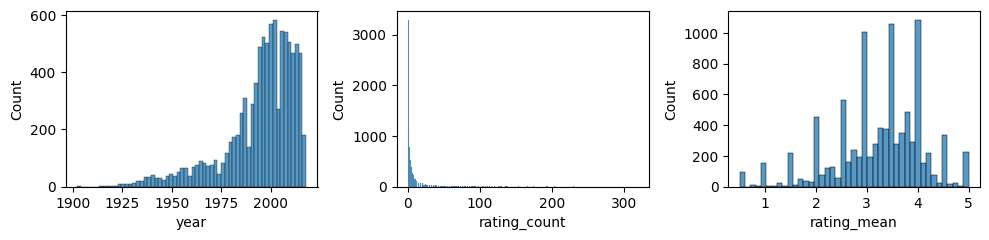

Détails rating_count


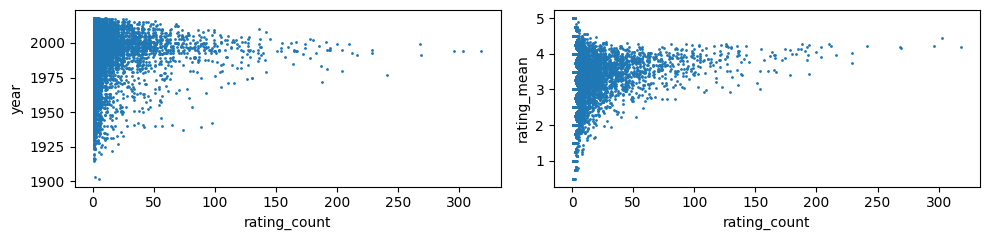

In [6]:
print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=3, figsize=(10, 2.5))

print("Détails rating_count")
plt.figure(figsize=(10, 2.5))

plt.subplot(121)
plt.scatter(quant_df.rating_count, quant_df.year, s=1)
plt.xlabel("rating_count")
plt.ylabel("year")

plt.subplot(122)
plt.scatter(quant_df.rating_count, quant_df.rating_mean, s=1)
plt.xlabel("rating_count")
plt.ylabel("rating_mean")

plt.tight_layout()
plt.show()

<font class="answer">
    
### *year*
Les films sont relativement récents: peak autour de l'an 2000. La base de données couvre un large spectre et la distribution est allongée: queue à gauche.
    
### *rating_count*
Les films sont majoritairement votés par peu de personnes. La distribution très alongée avec un très fort peak dans les faibles valeurs: 75% de la poputlation a moins de 9 votes, 25% n'en a qu'un seul. Je tentais d'interpréter cette métrique comme une mesure de "consensus" sur *rating* mais les 2 derniers graphes montrent bien que ce n'est pas le cas. Les spectres de *year* et *rating_mean* sont couvert. Cette métrique sera enlevée du clustering. 
    
### *rating_mean* 
Distrubution très près d'une gaussienne et multimodale. On voit bien l'effet des catégories. La majorités des votes sont entre [3, 4]

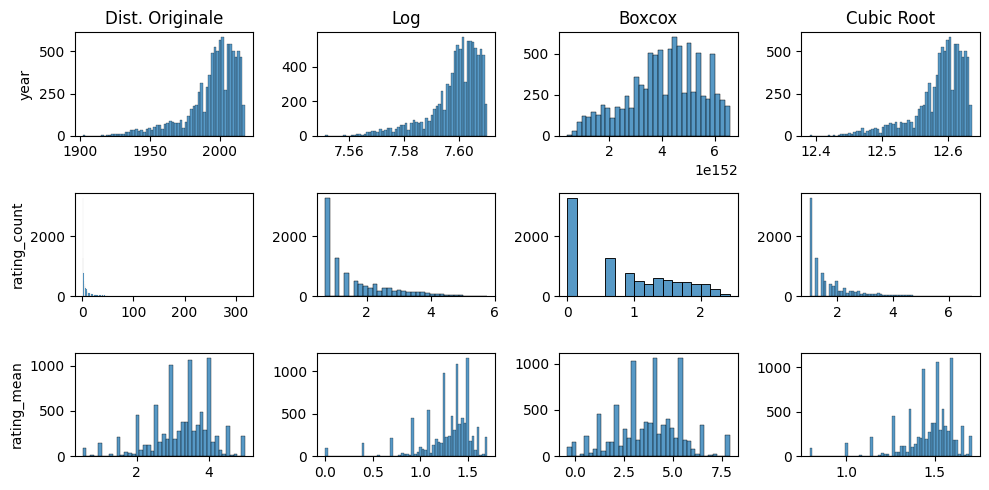

In [7]:
quant_transformed = clstr.show_transforms(quant_df, figsize=(10, 5))

**Faudrait montrer les outliers; quoiqu'on en a parler avant je pense**

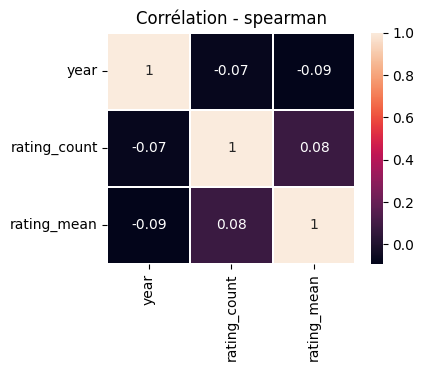

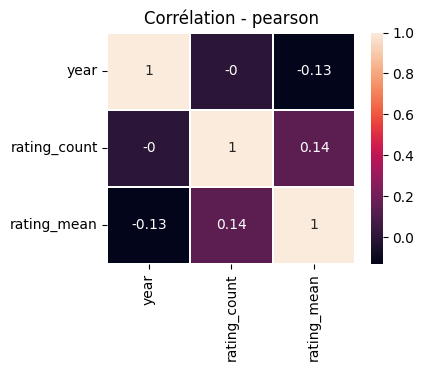

In [8]:
# #
# # enlever rating_count
# #
# movies_df.drop("rating_count", axis=1, inplace=True, errors="ignore")
# quant_df = quant_df.drop("rating_count", axis=1, errors="ignore")

#
# visualiser correlation
#
clstr.show_correlation(quant_df, method="spearman", figsize=(4, 3))
clstr.show_correlation(quant_df, method="pearson", figsize=(4, 3))

## Distributions - variables qualitatives

Distributions - variables qualitatives


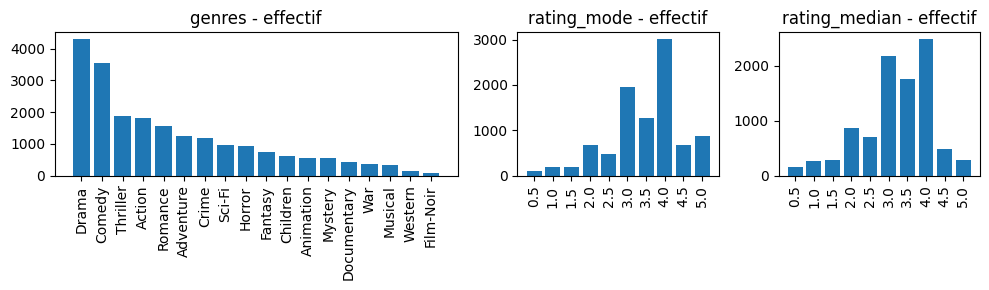

In [9]:
print("Distributions - variables qualitatives")
genres_count = {}
for genres_str in qual_df.genres:
    genre_array = genres_str.split(configs.dataset.genre_splitter)
    for genre in genre_array:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

genres_df = pd.Series(data=genres_count.values(),
                      index=genres_count.keys(),
                      name="count")
genres_df.sort_values(ascending=False, inplace=True)
rating_modes_df = qual_df.rating_mode.astype(str).value_counts()
rating_modes_df.sort_index(inplace=True)
rating_median_df = qual_df.rating_median.astype(str).value_counts()
rating_median_df.sort_index(inplace=True)

_, axes = plt.subplots(1, 3, width_ratios=[2, 1, 1], figsize=(10, 3))

axes[0].bar(genres_df.index, genres_df.values)
axes[0].tick_params(axis="x", labelrotation=90)
axes[0].set_title("genres - effectif")

axes[1].bar(rating_modes_df.index, rating_modes_df.values)
axes[1].tick_params(axis="x", labelrotation=90)
axes[1].set_title("rating_mode - effectif")

axes[2].bar(rating_median_df.index, rating_median_df.values)
axes[2].tick_params(axis="x", labelrotation=90)
axes[2].set_title("rating_median - effectif")

plt.tight_layout()
plt.show()

<font class="answer">
    
* Forte proportion dans Drama et Comedy
* Distributions de *rating_mode* et *rating_median* sont similaires en forme à *rating_mean*. Il m'apparait plus juste par contre de choisir *rating_mode* pour représenter la variable originelle *rating* de *ratings.csv*. Elle garde l'aspect qualitatif du système de notation et représente la mojorité des votes. *rating_mean* n'est pas adéquat car, comme vu plus haut, il y a peu données en général et elles contiennent le spectre complet du domaine.

year          -1.922822e-16
rating_mean   -4.581724e-17
dtype: float64


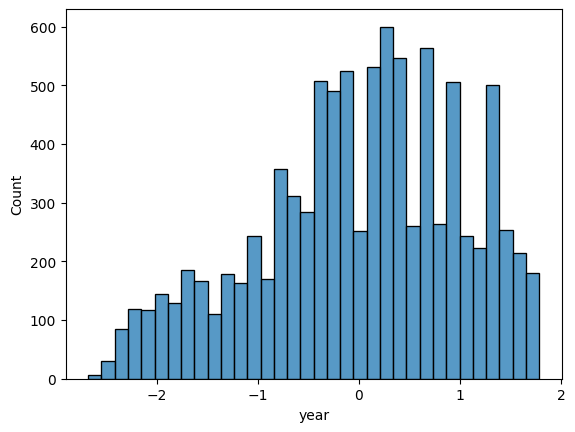

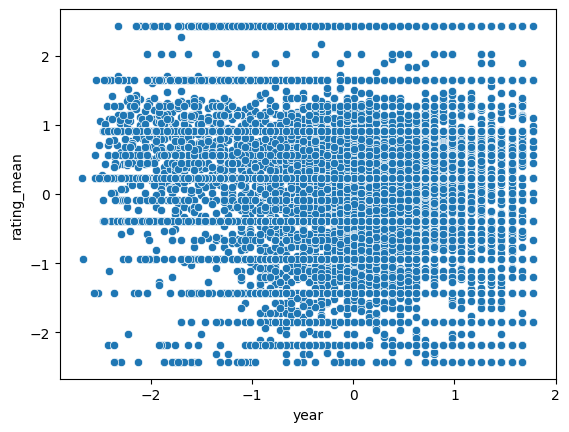

In [10]:
#
# regarder les ranges si on faisait afdm
#

# var numeriques
dd = StandardScaler().fit_transform(quant_transformed.boxcox[0][["year", "rating_mean"]])
dd = pd.DataFrame(dd, index=quant_df.index, columns=["year", "rating_mean"])

print(dd.mean())
sns.histplot(dd.year);
plt.show()


sns.scatterplot(x="year", y="rating_mean", data=dd)
plt.show()

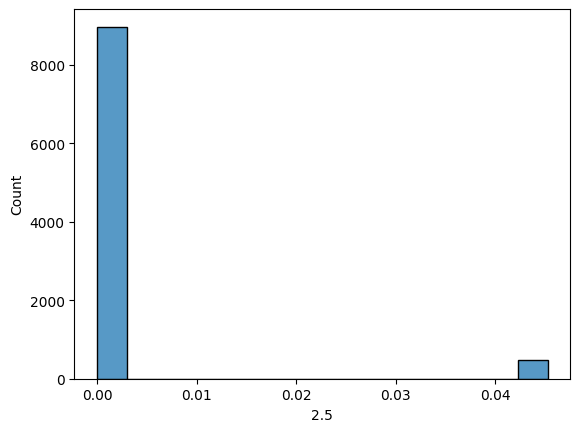

In [11]:
ratings_dummy = pd.get_dummies(qual_df.rating_mode, dtype=np.float64)

effectif = ratings_dummy.sum(axis=0)
freq = np.sqrt(effectif)

afdm_ = ratings_dummy.div(freq, axis=1)

# print(afdm_.mean())


sns.histplot(afdm_.iloc[:, 4]);


In [12]:
# #
# # enlever rating_mean et rating_median
# #
# rating_to_remove = ["rating_mean", "rating_median"]
# movies_df.drop(rating_to_remove, axis=1, inplace=True, errors="ignore")
# qual_df = qual_df.drop(rating_to_remove, axis=1, errors="ignore")

# # verification par inspection visuelle des colonnes restantes
# print(movies_df.columns.values)
# print(qual_df.columns.values)

<font class="answer">
 
Il apparaît plus approprié de catégoriser *year* plutot que de le garder en quantitatif étant donné la nature des autres variables. 3 catégories m'apparait raisonable (vieux films, films rétros et films actuel).

Compte par catégorie:


{Interval(1901.999, 1993.0, closed='right'): 3308,
 Interval(1993.0, 2005.0, closed='right'): 3204,
 Interval(2005.0, 2018.0, closed='right'): 2948}

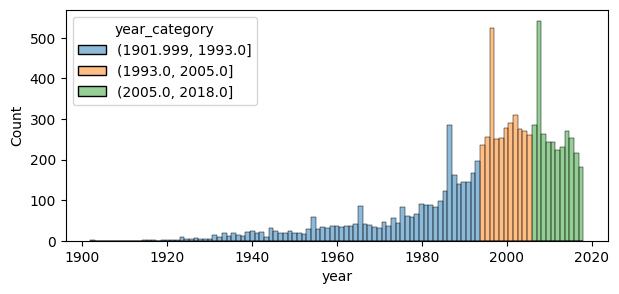

In [13]:
#
# categoriser selon les quantiles, 3 groupes
#
qcuts_ = [0, 1/3, 2/3, 1.0]
if "year_category" in movies_df.columns:
    movies_df.year_category = pd.qcut(movies_df.year, qcuts_),
else:
    movies_df.insert(loc=movies_df.columns.get_loc("year"),
                     column="year_category", 
                     value=pd.qcut(movies_df.year, qcuts_)),

# inspection categorisation
print("Compte par catégorie:")
unique, counts = np.unique(movies_df.year_category, return_counts=True)
display({v:c for v, c in zip(unique, counts)})

plt.figure(figsize=(7, 3))
sns.histplot(x="year",
             bins=movies_df.year.nunique(),
             data=movies_df, 
             hue=movies_df.year_category, 
             ax=plt.gca());
plt.show()

In [14]:
# #
# # enlever year
# #
# movies_df.drop("year", axis=1, inplace=True, errors="ignore")

# # verification par inspection visuelle des colonnes restantes
# print(movies_df.columns.values)

## Valeurs aberrantes<br>

<font class="answer">
Le prétraitement a valider et corrigé les divers individus qui semblaient être différents. L'exploration n'a pas montré de valeurs qui semblaient très différentes des domaines attendues. Aucune autre manipulation ne sera faite à cette effet.

## Clustering<br>
<font class="answer">
Les variables retenues sont donc:
    
* genres
* year_category
* rating_mode

In [15]:
#
# transformer les categories avec pandas.get_dummies()
#
def split_genres_str(genres_str):
    return genres_str.split(configs.dataset.genre_splitter)

genres_exploded = movies_df.genres.apply(split_genres_str).explode()
genres_dummies_df = pd.get_dummies(genres_exploded, prefix="genres").groupby(level=0).sum()

year_dummies_df = pd.get_dummies(movies_df.year_category, 
                                 prefix="year", 
                                 dtype=np.int64)

rating_mode_dummies_df = pd.get_dummies(movies_df.rating_mode, 
                                        prefix="rating_mode", 
                                        dtype=np.int64)

# agglomerer tous les resultats
acm_df = movies_df.iloc[:, 3:]
acm_dummies_df = pd.concat([year_dummies_df, genres_dummies_df, rating_mode_dummies_df], axis=1)

# validation
assert genres_dummies_df.shape[0] == movies_df.shape[0]
assert year_dummies_df.shape[0] == movies_df.shape[0]
assert rating_mode_dummies_df.shape[0] == movies_df.shape[0]
assert acm_dummies_df.shape[0] == movies_df.shape[0]

# inspection visuelle
print("Transformer par pandas.get_dummies() en prévisioin ACM")
display(acm_dummies_df)

Transformer par pandas.get_dummies() en prévisioin ACM


,"year_(1901.999, 1993.0]","year_(1993.0, 2005.0]","year_(2005.0, 2018.0]",genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,...,rating_mode_0.5,rating_mode_1.0,rating_mode_1.5,rating_mode_2.0,rating_mode_2.5,rating_mode_3.0,rating_mode_3.5,rating_mode_4.0,rating_mode_4.5,rating_mode_5.0
0,0,1,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9455,0,0,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9456,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9457,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9458,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
acm_sample_df = acm_df.sample(frac=0.2)
acm_dummies_sample_df = acm_dummies_df.iloc[acm_sample_df.index]

print(acm_df.shape)
print(acm_sample_df.shape)
print(acm_dummies_sample_df.shape)

(9460, 7)
(1892, 7)
(1892, 31)


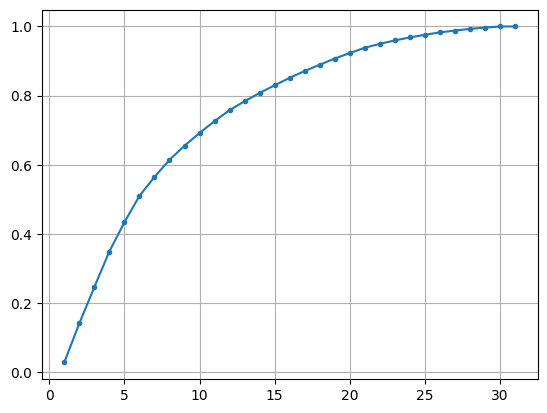

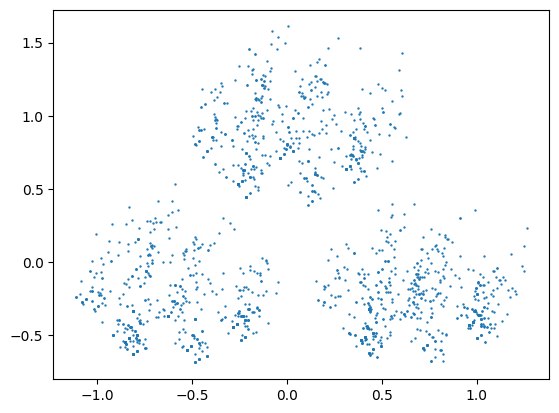

In [22]:
tsvd_sample = TruncatedSVD(n_components=31)
tsvd_sample_df = tsvd_sample.fit_transform(acm_dummies_sample_df)

ss = np.cumsum(tsvd_sample.explained_variance_ratio_)

plt.plot(range(1, ss.shape[0] + 1), ss, marker=".")
plt.grid(True)
plt.show()

plt.scatter(tsvd_sample_df[:, 1], tsvd_sample_df[:, 2], s=0.5)
plt.show()

In [45]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

dist_ = pairwise_distances(acm_dummies_sample_df, metric="hamming", n_jobs=-1)
      
mds_ = MDS(n_components=2, n_jobs=-1, dissimilarity="precomputed", normalized_stress=False)
mds_coords = mds_.fit_transform(dist_)

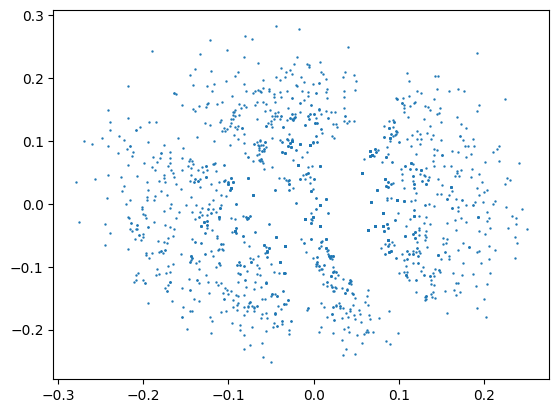

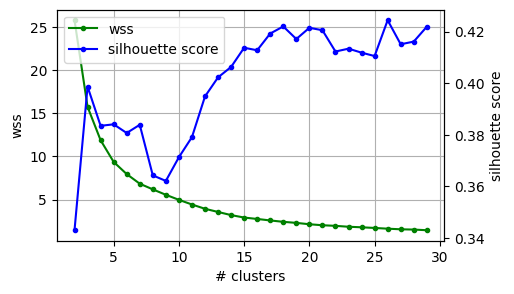

In [46]:
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], s=0.5)
plt.show()

clstr.kmeans_analysis(mds_coords, clusters_range=range(2, 30))

Silhouette score: 0.4055

Silhouette score par cluster
[0.4191, 0.4548, 0.3562, 0.3461, 0.3555, 0.6142, 0.4719, 0.4316, 0.3779, 0.262, 0.3502, 0.4184, 0.5611, 0.4017, 0.345, 0.3842, 0.3774, 0.2848, 0.5584, 0.3612, 0.2669, 0.3642, 0.391, 0.5, 0.2528, 0.3878]



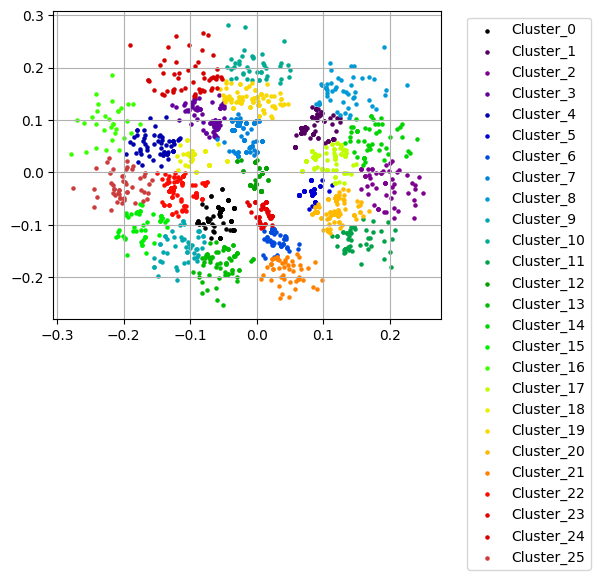

In [47]:
kmeans_ = clstr.kmeans_init(mds_coords, 26)
clstr.clusters_analysis(mds_coords, kmeans_.labels_)
clstr.show_clusters(mds_coords, 
                    acm_dummies_sample_df.index,
                    kmeans_.labels_,
                    text_alpha=0,
                    marker_size=5)

In [48]:
movies_ = acm_sample_df[kmeans_.labels_ == 0]
display(movies_[["year_category", "rating_mode"]].describe())

,year_category,rating_mode
count,106,106
unique,1,8
top,"(2005.0, 2018.0]",4.0
freq,106,45


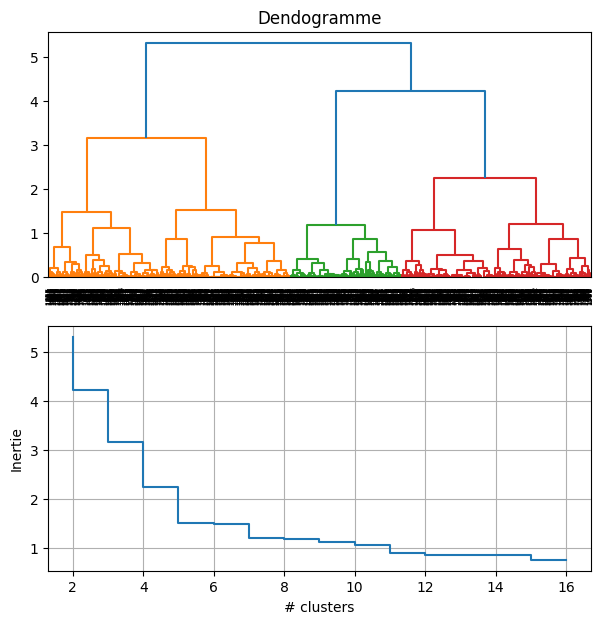

In [49]:
clstr.cah_analysis(mds_coords)

CAH clusters
Silhouette score: 0.369

Silhouette score par cluster
[0.2936, 0.3074, 0.4892, 0.301, 0.4773]



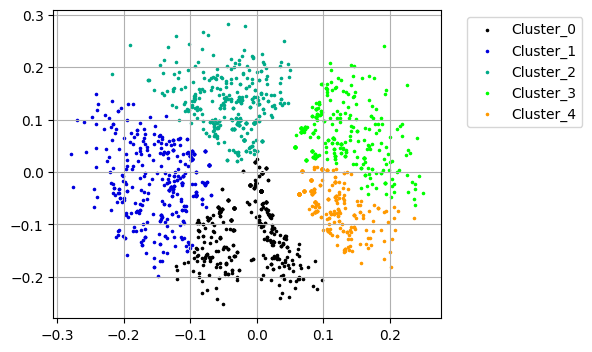

In [50]:
cah_movies = clstr.cah_init(mds_coords, 5)

print("CAH clusters")
clstr.clusters_analysis(mds_coords, cah_movies.labels_)
clstr.show_clusters(mds_coords, 
                    acm_dummies_sample_df.index,
                    cah_movies.labels_,
                    text_alpha=0,
                    marker_size=2.5)

In [52]:
movies_ = acm_sample_df[cah_movies.labels_ == 0]
display(movies_[["year_category", "rating_mode"]].describe())

,year_category,rating_mode
count,456,456
unique,2,10
top,"(1901.999, 1993.0]",4.0
freq,268,204


In [ ]:
class MCA_from_dummies(Base):
    def __init__(self, n_components=None, row_labels=None, var_labels=None, stats=True):
        Base.__init__(self, n_components, row_labels, None, stats)
        self.var_labels = var_labels
        
    def prefit(self, X, X_dummies):
        # Set columns prefixes
        self.n_vars_ = X.shape[1]
        self.prefixes_ = self.prefixes_ = [str(x) + "_" for x in self.var_labels]
        self.col_labels_short_temp_ = [x.split("_")[-1] for x in X_dummies.columns]
        self.col_labels_temp_ = X_dummies.columns
                
        # Dummy variables creation
        self.n_categories_ = X_dummies.shape[1]
    
    def fit(self, X_dummies, y=None):
        # Fit a Factorial Analysis to the dummy variables table
        self.r_ = np.sum(X_dummies, axis=1).reshape(-1, 1)
        Base.fit(self, X_dummies, y=None)
        
        # Adjustment of the number of components
        n_eigen = self.n_categories_ - self.n_vars_
        if (self.n_components_ > n_eigen):
            self.n_components_ = n_eigen
            self.eig_ = self.eig_[:, :self.n_components_]
            self.row_coord_ = self.row_coord_[:, :self.n_components_]
            self.col_coord_ = self.col_coord_[:, :self.n_components_]
            if self.stats:
                self.row_contrib_ = self.row_contrib_[:, :self.n_components_]
                self.col_contrib_ = self.col_contrib_[:, :self.n_components_]
                self.row_cos2_ = self.row_cos2_[:, :self.n_components_]
                self.col_cos2_ = self.col_cos2_[:, :self.n_components_]

        # Set col_labels_short_
        self.col_labels_short_ = self.col_labels_short_temp_
        
        # Set col_labels_
        self.col_labels_ = self.col_labels_temp_        
        
        self.model_ = "mca"
        
        return self
                        
def acm_init(data, n_components, data_dummies=None):
    if data_dummies is None:
        acm = MCA(n_components=n_components,
                  row_labels=data.index,
                  var_labels=data.columns)
        acm.fit(data.to_numpy())
    else:
        acm = MCA_from_dummies(n_components=n_components,
                               row_labels=data.index,
                               var_labels=data.columns)
        
        acm.prefit(data, data_dummies)        
        acm.fit(data_dummies.to_numpy())
    
    return acm

def acm_analysis(data, data_dummies=None, figsize=(4, 2.5)):
    """
    Le threshold est ~60% sur cumul var. expliquee
    """
    acm = acm_init(data, None, data_dummies=data_dummies)

    threshold = 1 / acm.n_vars_
    eig_vals = acm.eig_[0]
    eig_th = eig_vals[eig_vals > threshold]

    print("Valeurs propres:")
    print(acm.eig_[0].round(4))
    print()
    print(f"Valeurs propres > {round(threshold, 4)} (1 / p):")
    print(eig_th.round(4))
    print()
    print("Variance expliquee %:")
    print(acm.eig_[1].round(1))
    print()
    print("Variance expliquee cumul. %:")
    print(acm.eig_[2].round(1))
    print()

    num_eigval = len(acm.eig_[0])

    plt.figure(figsize=figsize)
    plt.plot(range(1, num_eigval + 1), acm.eig_[0], marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("Valeur propre")
    plt.show()

acm_analysis(data=acm_sample_df, data_dummies=acm_dummies_sample_df)

In [ ]:
acm_ = acm_init(data=acm_sample_df, data_dummies=acm_dummies_sample_df, n_components=21)

plt.scatter(acm_.row_coord_[:, 0], acm_.row_coord_[:, 1], s=0.5)
plt.show()

In [ ]:
clstr.cah_analysis(acm_.row_coord_)

In [ ]:
cah_movies = clstr.cah_init(acm_.row_coord_, 5)

print("CAH clusters")
clstr.clusters_analysis(acm_.row_coord_, cah_movies.labels_)
clstr.show_clusters(acm_.row_coord_[:, [0, 1]], 
                    acm_.row_labels_,
                    cah_movies.labels_,
                    text_alpha=0,
                    marker_size=2.5)

In [ ]:
clstr.dbscan_eps_analysis(acm_.row_coord_)

In [ ]:
eps_, min_samples_ = clstr.dbscan_parameters_analysis(acm_.row_coord_,
                                                      np.arange(0.4, 1.4, 0.1),
                                                      range(3, 20))
dbscan_movies = clstr.dbscan_init(acm_.row_coord_, eps_, min_samples_)

print()
print("DBSCAN clusters")
clstr.clusters_analysis(acm_.row_coord_, dbscan_movies.labels_)

In [ ]:
clstr.show_clusters(acm_.row_coord_[:, [0, 1]], 
                    acm_.row_labels_,
                    dbscan_movies.labels_,
                    text_alpha=0,
                    marker_size=2.5)

In [ ]:
from kmodes.kmodes import KModes

kmodes_movies = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1, n_jobs=-1)
kmodes_movies.fit(acm_.row_coord_)

print("KModes clusters")
clstr.clusters_analysis(acm_.row_coord_, kmodes_movies.labels_)

clstr.show_clusters(acm_.row_coord_[:, [0, 1]], 
                    acm_.row_labels_,
                    kmodes_movies.labels_,
                    text_alpha=0,
                    marker_size=2.5)